# EV3 L-motor 5v pwm

In [2]:
import math
import copy
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
import control
import datetime

from control import matlab
from control.matlab import *
from scipy import signal
from sklearn.linear_model import LinearRegression

from Modules import Modules

%matplotlib inline

print("OK\n")

OK



In [3]:
def lowpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2   #ナイキスト周波数
    wp = fp / fn  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn  #ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
    b, a = signal.butter(N, Wn, "low")            #フィルタ伝達関数の分子と分母を計算
    y = signal.filtfilt(b, a, x)                  #信号に対してフィルタをかける
    return y

In [4]:
def calc_poly(df_value):
    #近似式の係数
    y = df_value
    res1=np.polyfit(x, y, 1)
    res2=np.polyfit(x, y, 2)
    res3=np.polyfit(x, y, 3)
    #近似式の計算
    y1 = np.poly1d(res1)(x) #1次
    y2 = np.poly1d(res2)(x) #2次
    y3 = np.poly1d(res3)(x) #3次
    
    #グラフ表示
    plt.scatter(x, y, label='元データ')
    plt.plot(x, y1, label='1次')
    plt.plot(x, y2, label='2次')
    plt.plot(x, y3, label='3次')
    plt.legend()
    plt.show()
    return y1,y2,y3

In [5]:
# 2次系伝達関数モデル作成の関数
def tf_2nd_order(zeta, wn):
   num = [math.pow(wn, 2)]
   den = [1, 2*zeta*wn, math.pow(wn, 2)]
   G = matlab.tf(num, den)
   return G

In [6]:
def get_peak(output, t):
    t_peak = 0
    a_max = 0
    for i, y in enumerate(output):
        if y > a_max:
            a_max = y
            t_peak = t[i]
    return a_max, t_peak

In [7]:
def calc_param_ab(a_max, t_peak, Kp, z_c):
    gumma_c = (1/t_peak) * math.log((z_c/a_max))
    delta_c = math.pi/t_peak
    omega_nc = math.sqrt(math.pow(gumma_c, 2) + math.pow(delta_c, 2))
    zeta_c = gumma_c/omega_nc
    print("omega_nc : " +str(omega_nc))
    print("zeta_c : " + str(zeta_c))
    a_m = 2 * zeta_c * omega_nc
    b_m = ((math.pow(omega_nc, 2))/Kp)
    return a_m, b_m

In [8]:
def plot_line(output, t, z_c, x_max, y_max):
    # 出力パラメータ
    plt.plot(t, z_c * output)
    plt.axhline(z_c, ls=":", color="blue")
    
    # グラフ表示設定
    plt.rcParams['font.family'] = 'Times New Roman' # 全体のフォント
    plt.title('2nd order step', fontsize=10)        # グラフタイトル
    plt.xlabel('time [sec]', fontsize=10)           # x軸ラベル
    plt.ylabel('speed [deg/s]', fontsize=10)               # y軸ラベル
    plt.xlim([0, x_max])                              # x軸範囲
    plt.ylim([0, y_max])                              # y軸範囲
    plt.tick_params(labelsize = 10)                 # 軸ラベルの目盛りサイズ
    plt.tight_layout()                              # ラベルがきれいに収まるよう表示
    plt.grid()                                      # グリッド表示
    plt.show()    

In [9]:
def plot_line_over_experimental_data(output, t, z_c, x_max, y_max, t_ex, y_ex):
    # 出力パラメータ
    plt.plot(t, z_c * output)
    plt.plot(t_ex ,y_ex)
    plt.axhline(z_c, ls=":", color="blue")
        
    # グラフ表示設定
    plt.rcParams['font.family'] = 'Times New Roman' # 全体のフォント
    plt.title('2nd order step', fontsize=10)        # グラフタイトル
    plt.xlabel('time [sec]', fontsize=10)           # x軸ラベル
    plt.ylabel('speed [deg/s]', fontsize=10)               # y軸ラベル
    plt.xlim([0, x_max])                              # x軸範囲
    plt.ylim([0, y_max])                              # y軸範囲
    plt.tick_params(labelsize = 10)                 # 軸ラベルの目盛りサイズ
    plt.tight_layout()                              # ラベルがきれいに収まるよう表示
    plt.grid()                                      # グリッド表示
    plt.show()

In [10]:
def calc_dps(df):
    calc_data = []
    before_dps_a = 0
    before_dps_d = 0
    time = 0
    for index, row in df.iterrows():
        time = time + row['delta']
        if row['a_position'] == 0:
            delta_theata_a = 0
            delta_theata_d = 0
            dps_a = 0
            dps_d = 0
            delta_a_speed = 0
            delta_d_speed = 0
            delta_a_dps = 0
            delta_d_dps = 0
            rps_a = 0
            rps_d = 0
            acc_a = 0
            acc_d = 0
            accr_a = 0
            accr_d = 0
        else:
            # 1ステップ前の相対角度(観測値)との差分から⊿θを導出
            delta_theata_a = row['delta_theta_a']
            delta_theata_d = row['delta_theta_d']
            # １ステップ前からの角度の変化量⊿θと時間変化⊿tの商から角速度deg/secを導出
            dps_a = delta_theata_a/row['delta']
            dps_d = delta_theata_d/row['delta']
            # １ステップ前との速度変化(観測値)を導出
            delta_a_speed = 0
            delta_d_speed = 0
            # 1ステップ前の角速度との差分から⊿ωを導出
            delta_a_dps = dps_a - before_dps_a
            delta_d_dps = dps_d - before_dps_d
            #
            rps_a = dps_a * math.pi/180
            rps_d = dps_d * math.pi/180
            # 速度の変化量と⊿tの商から角加速度deg/sec^2 を導出
            acc_a = dps_a / row['delta']
            acc_d = dps_d / row['delta']
            #
            accr_a = acc_a * math.pi/180
            accr_d = acc_d * math.pi/180
        # 行データを配列にセット
        line = {
            'delta': row['delta']
            ,'time': time
            ,'acc_a': acc_a
            ,'dps_a': dps_a
            ,'rps_a': rps_a
            ,'accr_a': accr_a
            ,'a_speed': row['a_speed']
            ,'delta_a_speed': delta_a_speed
            ,'delta_a_dps': delta_a_dps
            ,'delta_theata_a': delta_theata_a
            ,'a_position': row['a_position']
            ,'acc_d': acc_d
            ,'dps_d': dps_d
            ,'rps_d': rps_d
            ,'accr_d': accr_d
            ,'d_speed': row['d_speed']
            ,'delta_d_dps': delta_d_dps
            ,'delta_d_speed': delta_d_speed
            ,'delta_theata_d': delta_theata_d
            ,'d_position': row['d_position']
        }
        calc_data.append(line)
        before_dps_a = dps_a
        before_dps_d = dps_d
    
    df2 = pd.DataFrame(calc_data)
    samplerate = 1.0 / (time / 300)
    print(time)
    print(samplerate)
    return df2

26.46944689750671
11.333822016064056
21.41816735267639
14.006800631451425
25.942749738693237
11.563924526957694
20.840808868408203
14.394834763575743
20.34524536132812
14.74545991813078
17.77410054206848
16.878491223223786
19.89916586875915
15.07600881255969
22.66129493713379
13.238431467939058
23.856800317764282
12.575030850914805
21.138416051864624
14.19217027727756


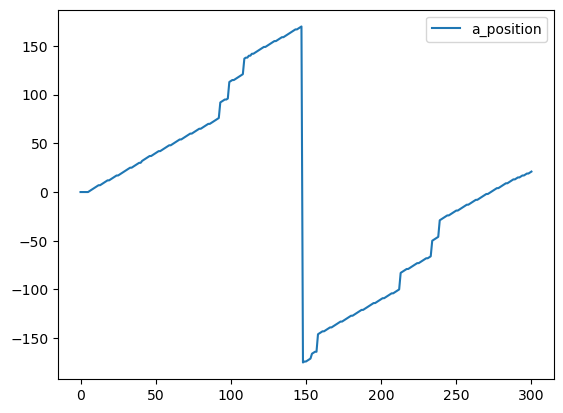

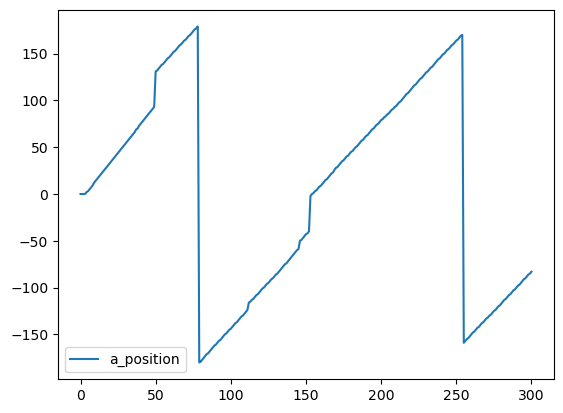

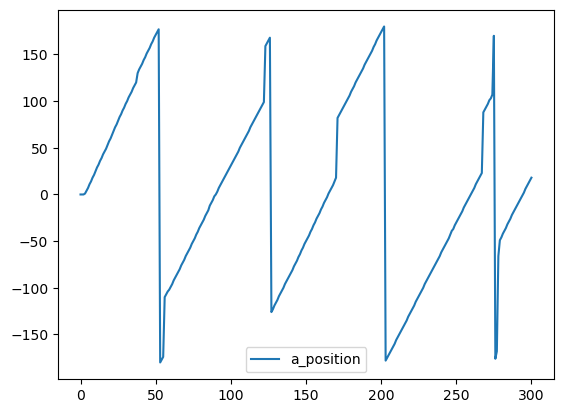

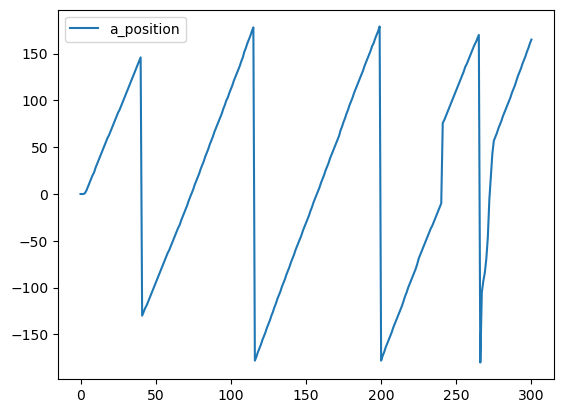

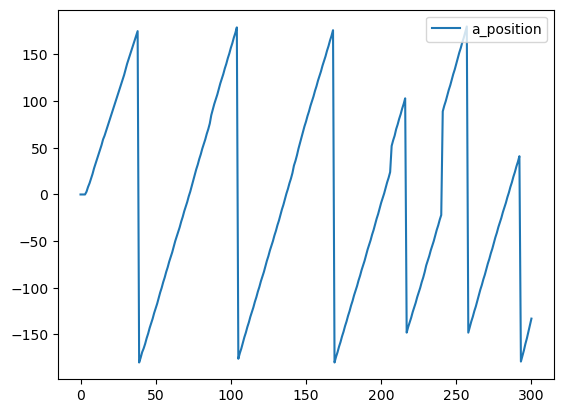

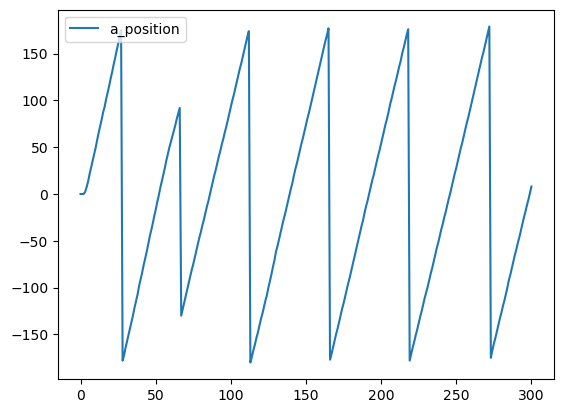

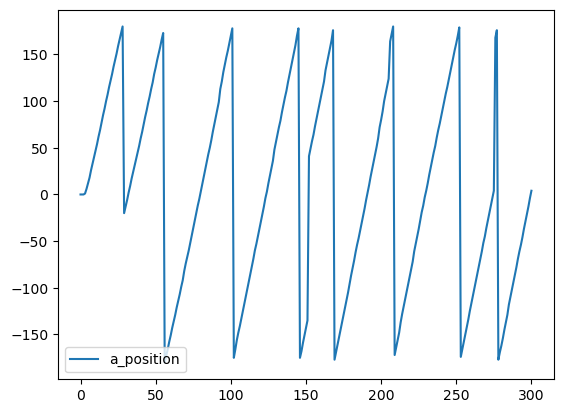

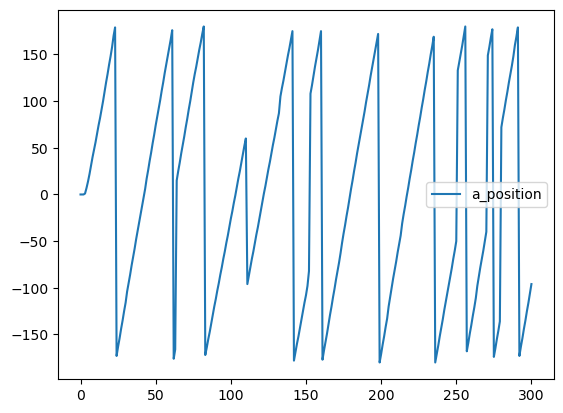

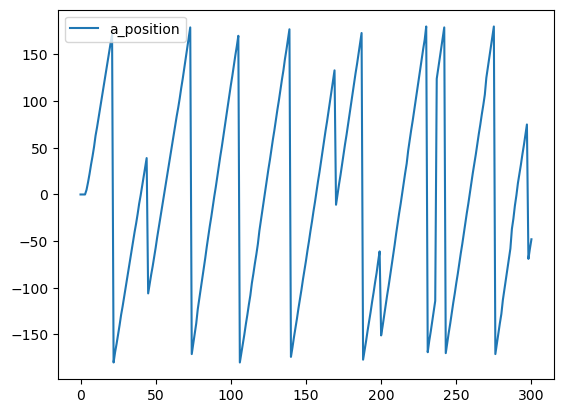

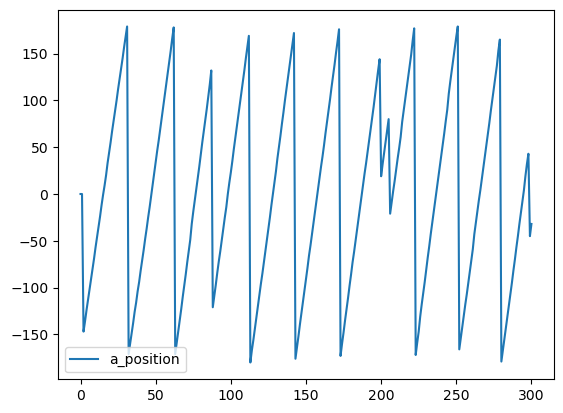

In [11]:
file_index = '01'
df9v10 = pd.read_csv('./5.5v/20240411/param_ev3-speed-001_5v-10_20240411.tsv')
df9v20 = pd.read_csv('./5.5v/20240411/param_ev3-speed-002_5v-20_20240411.tsv')
df9v30 = pd.read_csv('./5.5v/20240411/param_ev3-speed-003_5v-30_20240411.tsv')
df9v40 = pd.read_csv('./5.5v/20240411/param_ev3-speed-004_5v-40_20240411.tsv')
df9v50 = pd.read_csv('./5.5v/20240411/param_ev3-speed-005_5v-50_20240411.tsv')
df9v60 = pd.read_csv('./5.5v/20240411/param_ev3-speed-006_5v-60_20240411.tsv')
df9v70 = pd.read_csv('./5.5v/20240411/param_ev3-speed-007_5v-70_20240411.tsv')
df9v80 = pd.read_csv('./5.5v/20240411/param_ev3-speed-008_5v-80_20240411.tsv')
df9v90 = pd.read_csv('./5.5v/20240411/param_ev3-speed-009_5v-90_20240411.tsv')
df9v100 = pd.read_csv('./5.5v/20240411/param_ev3-speed-010_5v-100_20240411.tsv')
df9v10.plot(y='a_position')
df9v20.plot(y='a_position')
df9v30.plot(y='a_position')
df9v40.plot(y='a_position')
df9v50.plot(y='a_position')
df9v60.plot(y='a_position')
df9v70.plot(y='a_position')
df9v80.plot(y='a_position')
df9v90.plot(y='a_position')
df9v100.plot(y='a_position')
df9v10_2 = calc_dps(df9v10)
df9v20_2 = calc_dps(df9v20)
df9v30_2 = calc_dps(df9v30)
df9v40_2 = calc_dps(df9v40)
df9v50_2 = calc_dps(df9v50)
df9v60_2 = calc_dps(df9v60)
df9v70_2 = calc_dps(df9v70)
df9v80_2 = calc_dps(df9v80)
df9v90_2 = calc_dps(df9v90)
df9v100_2 = calc_dps(df9v100)

In [12]:
df9v10_2

,delta,time,acc_a,dps_a,rps_a,accr_a,a_speed,delta_a_speed,delta_a_dps,delta_theata_a,a_position,acc_d,dps_d,rps_d,accr_d,d_speed,delta_d_dps,delta_d_speed,delta_theata_d,d_position
0,0.000002,0.000002,0.000000,0.000000,0.000000,0.000000,0.0,0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0,0.0,0.0
1,0.132853,0.132855,0.000000,0.000000,0.000000,0.000000,0.0,0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0,0.0,0.0
2,0.057809,0.190664,0.000000,0.000000,0.000000,0.000000,0.0,0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0,0.0,0.0
3,0.049259,0.239922,0.000000,0.000000,0.000000,0.000000,0.0,0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0,0.0,0.0
4,0.048976,0.288898,0.000000,0.000000,0.000000,0.000000,0.0,0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,0.060093,26.224073,276.919346,16.640894,0.290438,4.833154,0.0,0,16.640894,1.0,18.0,276.919346,16.640894,0.290438,4.833154,0.0,-0.208911,0,1.0,-74.0
297,0.056252,26.280326,316.024200,17.777069,0.310268,5.515663,0.0,0,1.136176,1.0,19.0,0.000000,0.000000,0.000000,0.000000,0.0,-16.640894,0,0.0,-74.0
298,0.056894,26.337219,0.000000,0.000000,0.000000,0.000000,0.0,0,-17.777069,0.0,19.0,308.939448,17.576673,0.306771,5.392011,0.0,17.576673,0,1.0,-73.0
299,0.055612,26.392831,323.341619,17.981702,0.313840,5.643376,0.0,0,17.981702,1.0,20.0,0.000000,0.000000,0.000000,0.000000,0.0,-17.576673,0,0.0,-73.0


In [13]:
# https://atatat.hatenablog.com/entry/data_proc_python4
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.buttord.html
time = 6.727645635604856
samplerate = 44.59212274979287
fp = 5.8 # 通過域端周波数[Hz]：指定した周波数以下は減衰を受けない
fs = 5.9# 阻止域端周波数[Hz]：指定した周波数以上は減衰を受ける
gpass = 38 # 通過域端最大損失[dB]
gstop = 38.1 # 阻止域端最小損失[dB]
x = np.arange(0, 301) / samplerate

## 計算値に対してBOF適用

### デューティー比が10

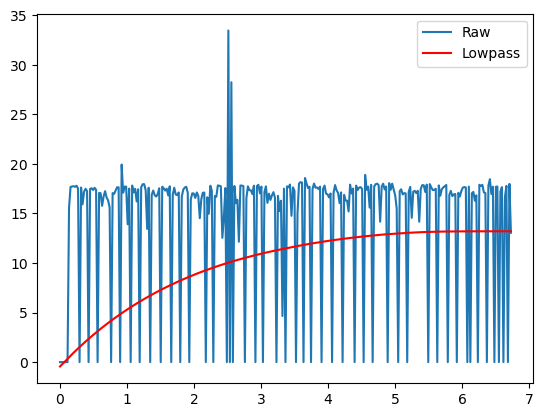

In [16]:
a_df_int = df9v10_2['dps_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v10_2['dps_a_filterd'] = data_lofilt

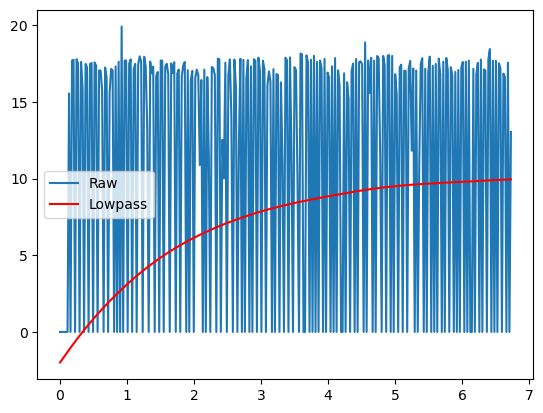

In [17]:
a_df_int = df9v10_2['dps_d'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v10_2['dps_d_filterd'] = data_lofilt

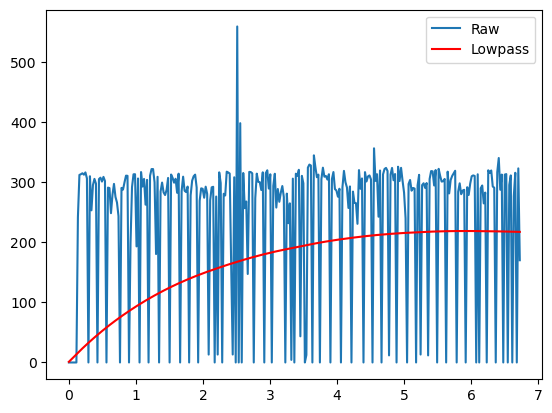

In [18]:
a_df_int = df9v10_2['acc_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v10_2['acc_a_filterd'] = data_lofilt

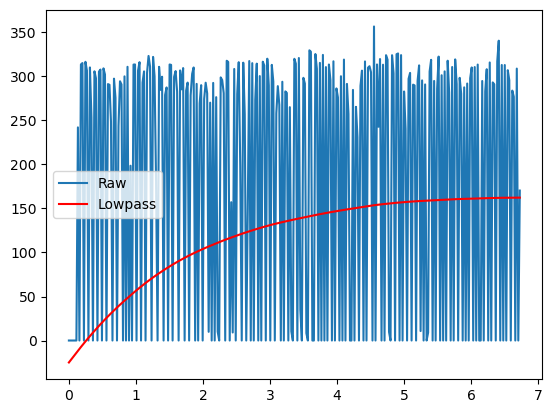

In [19]:
a_df_int = df9v10_2['acc_d'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v10_2['acc_d_filterd'] = data_lofilt

### デューティー比が20

In [21]:
### https://atatat.hatenablog.com/entry/data_proc_python4
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.buttord.html
time = 6.727645635604856
samplerate = 44.59212274979287
fp = 5.8 # 通過域端周波数[Hz]：指定した周波数以下は減衰を受けない
fs = 5.9# 阻止域端周波数[Hz]：指定した周波数以上は減衰を受ける
gpass = 38 # 通過域端最大損失[dB]
gstop = 38.1 # 阻止域端最小損失[dB]
x = np.arange(0, 301) / samplerate

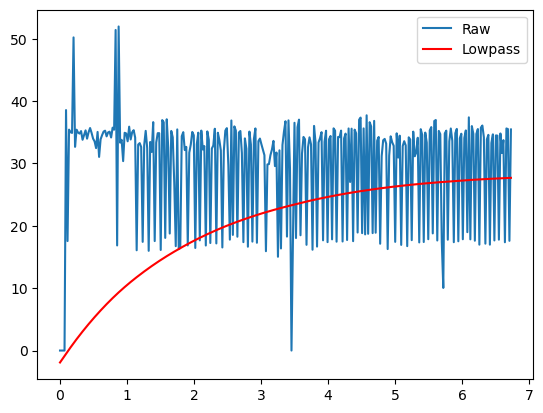

In [22]:
a_df_int = df9v20_2['dps_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v20_2['dps_a_filterd'] = data_lofilt

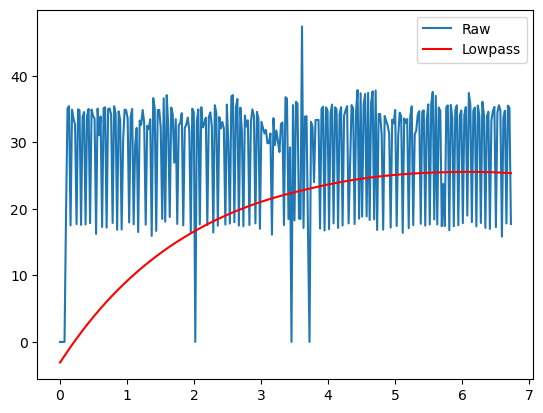

In [23]:
a_df_int = df9v20_2['dps_d'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v20_2['dps_d_filterd'] = data_lofilt

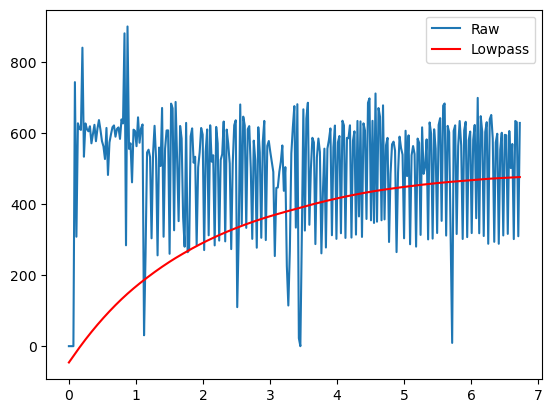

In [24]:
a_df_int = df9v20_2['acc_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v20_2['acc_a_filterd'] = data_lofilt

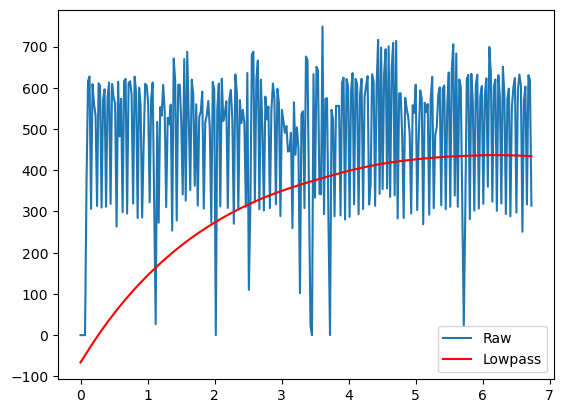

In [25]:
a_df_int = df9v20_2['acc_d'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v20_2['acc_d_filterd'] = data_lofilt

### デューティー比が30

In [27]:
fp = 5.8 # 通過域端周波数[Hz]：指定した周波数以下は減衰を受けない
fs = 5.9# 阻止域端周波数[Hz]：指定した周波数以上は減衰を受ける
gpass = 33 # 通過域端最大損失[dB]
gstop = 33.1 # 阻止域端最小損失[dB]
x = np.arange(0, 301) / samplerate

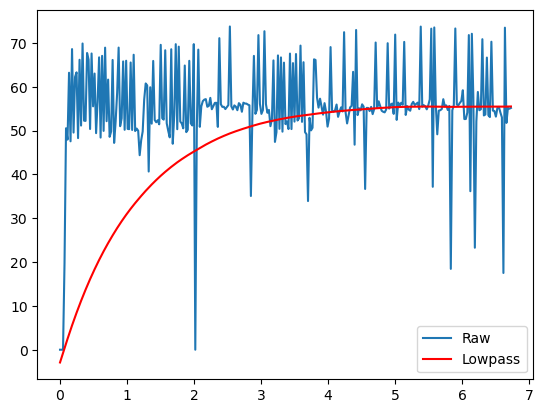

In [28]:
a_df_int = df9v30_2['dps_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v30_2['dps_a_filterd'] = data_lofilt

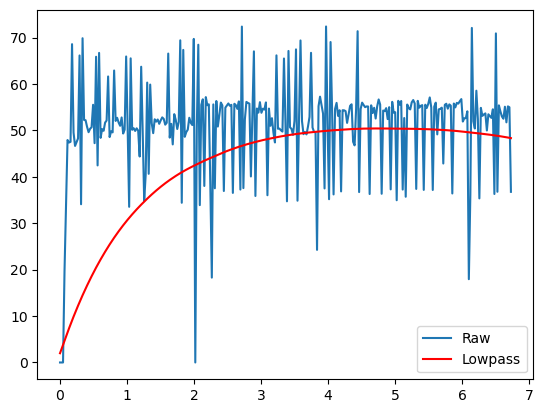

In [29]:
a_df_int = df9v30_2['dps_d'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v30_2['dps_d_filterd'] = data_lofilt

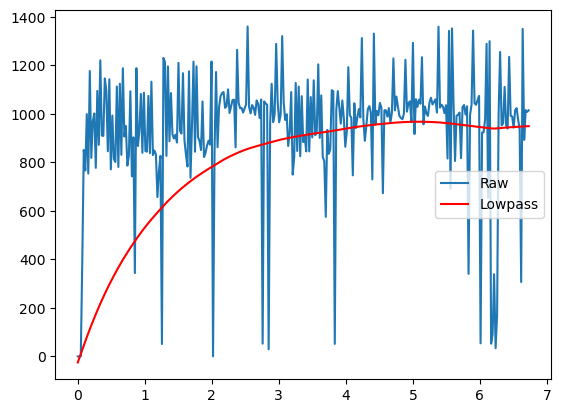

In [30]:
a_df_int = df9v30_2['acc_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v30_2['acc_a_filterd'] = data_lofilt

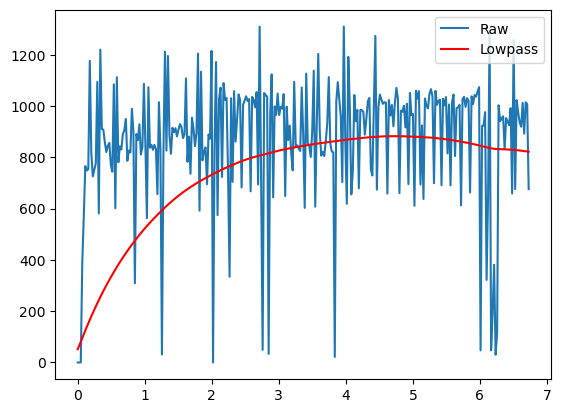

In [31]:
a_df_int = df9v30_2['acc_d'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v30_2['acc_d_filterd'] = data_lofilt

### デューティー比が40

In [33]:
fp = 5.8 # 通過域端周波数[Hz]：指定した周波数以下は減衰を受けない
fs = 5.9# 阻止域端周波数[Hz]：指定した周波数以上は減衰を受ける
gpass = 33 # 通過域端最大損失[dB]
gstop = 33.1 # 阻止域端最小損失[dB]
x = np.arange(0, 301) / samplerate

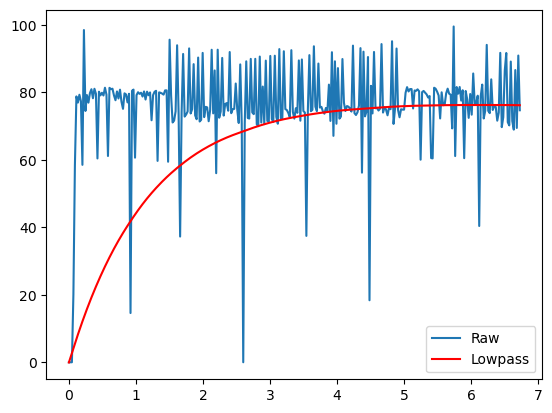

In [34]:
a_df_int = df9v40_2['dps_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v40_2['dps_a_filterd'] = data_lofilt

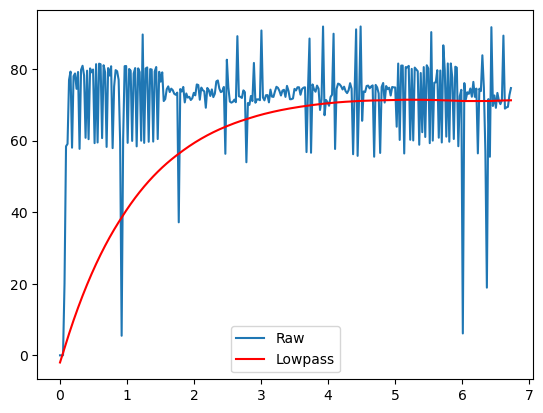

In [35]:
a_df_int = df9v40_2['dps_d'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v40_2['dps_d_filterd'] = data_lofilt

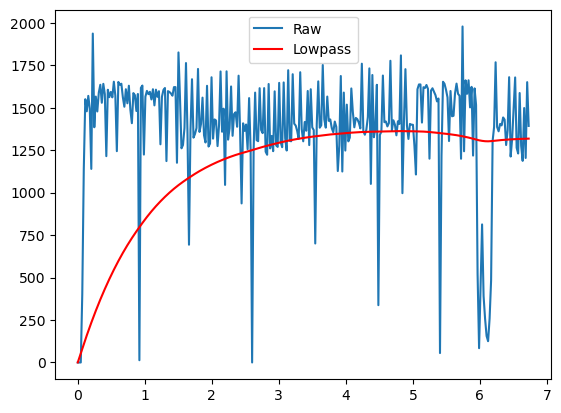

In [36]:
a_df_int = df9v40_2['acc_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v40_2['acc_a_filterd'] = data_lofilt

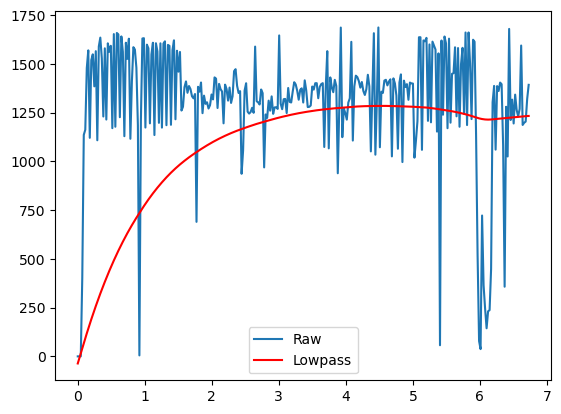

In [37]:
a_df_int = df9v40_2['acc_d'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v40_2['acc_d_filterd'] = data_lofilt

### デューティー比が50

In [39]:
fp = 5.8 # 通過域端周波数[Hz]：指定した周波数以下は減衰を受けない
fs = 5.9# 阻止域端周波数[Hz]：指定した周波数以上は減衰を受ける
gpass = 33 # 通過域端最大損失[dB]
gstop = 33.1 # 阻止域端最小損失[dB]
x = np.arange(0, 301) / samplerate

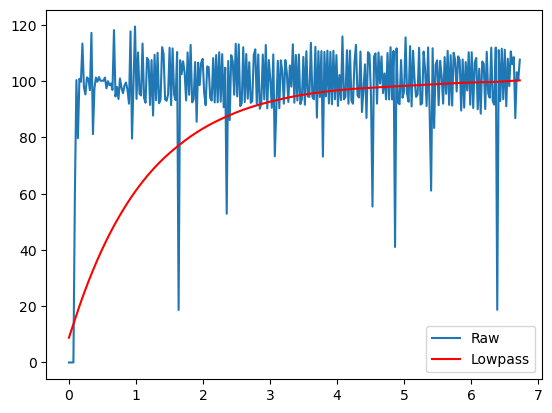

In [40]:
a_df_int = df9v50_2['dps_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v50_2['dps_a_filterd'] = data_lofilt

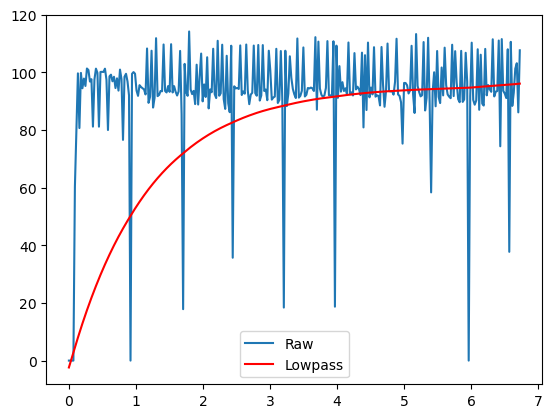

In [41]:
a_df_int = df9v50_2['dps_d'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v50_2['dps_d_filterd'] = data_lofilt

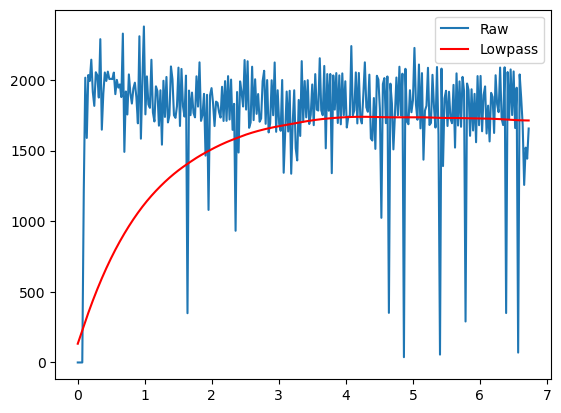

In [42]:
a_df_int = df9v50_2['acc_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v50_2['acc_a_filterd'] = data_lofilt

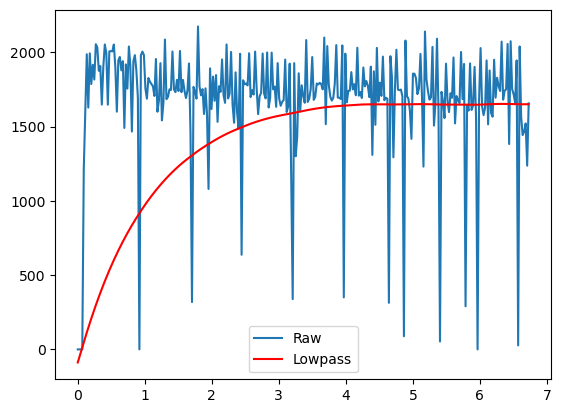

In [43]:
a_df_int = df9v50_2['acc_d'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v50_2['acc_d_filterd'] = data_lofilt

### デューティー比が60

In [45]:
fp = 5.8 # 通過域端周波数[Hz]：指定した周波数以下は減衰を受けない
fs = 5.9# 阻止域端周波数[Hz]：指定した周波数以上は減衰を受ける
gpass = 33 # 通過域端最大損失[dB]
gstop = 33.1 # 阻止域端最小損失[dB]
x = np.arange(0, 301) / samplerate

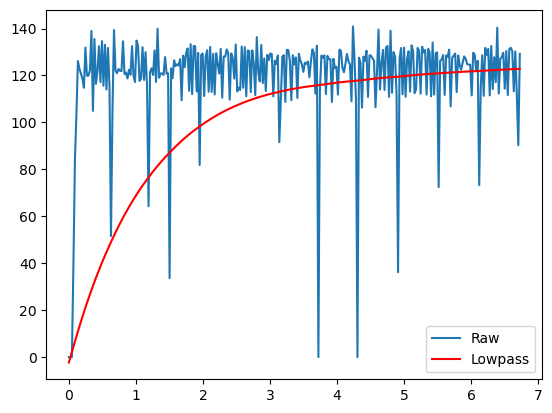

In [46]:
a_df_int = df9v60_2['dps_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v60_2['dps_a_filterd'] = data_lofilt

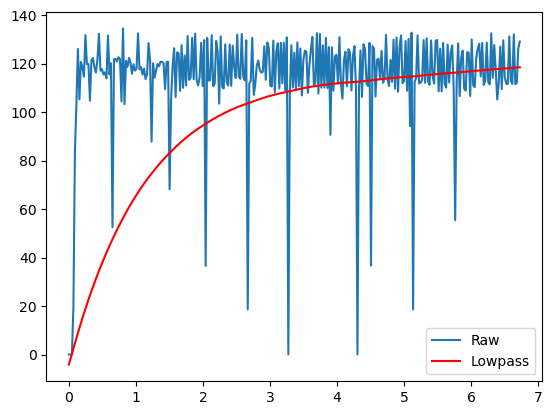

In [47]:
a_df_int = df9v60_2['dps_d'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v60_2['dps_d_filterd'] = data_lofilt

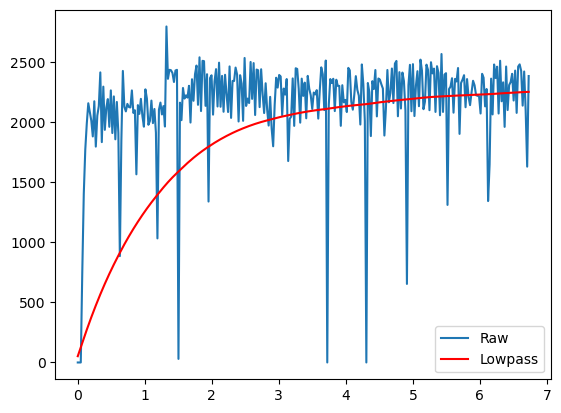

In [48]:
a_df_int = df9v60_2['acc_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v60_2['acc_a_filterd'] = data_lofilt

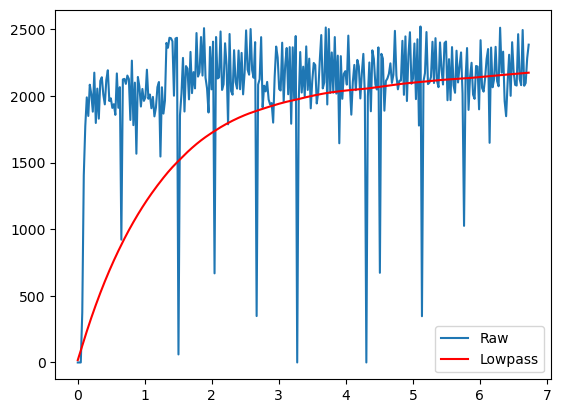

In [49]:
a_df_int = df9v60_2['acc_d'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v60_2['acc_d_filterd'] = data_lofilt

### デューティー比が70

In [51]:
fp = 5.8 # 通過域端周波数[Hz]：指定した周波数以下は減衰を受けない
fs = 5.9# 阻止域端周波数[Hz]：指定した周波数以上は減衰を受ける
gpass = 33 # 通過域端最大損失[dB]
gstop = 33.1 # 阻止域端最小損失[dB]
x = np.arange(0, 301) / samplerate

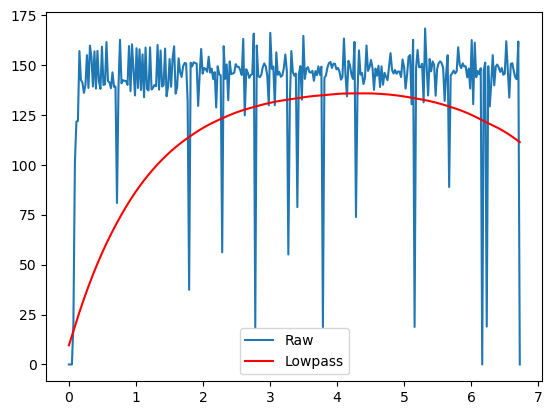

In [52]:
a_df_int = df9v70_2['dps_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v70_2['dps_a_filterd'] = data_lofilt

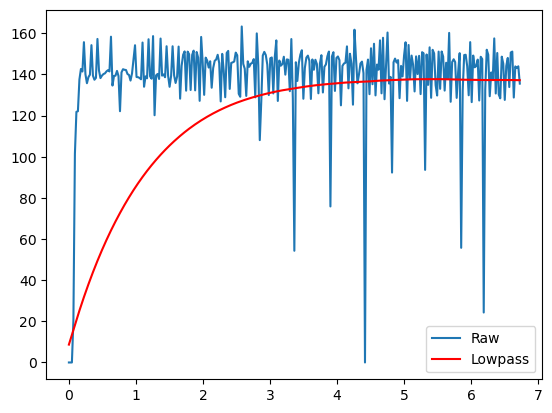

In [53]:
a_df_int = df9v70_2['dps_d'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v70_2['dps_d_filterd'] = data_lofilt

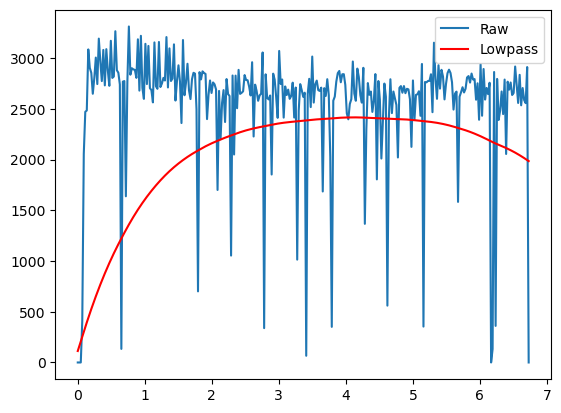

In [54]:
a_df_int = df9v70_2['acc_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v70_2['acc_a_filterd'] = data_lofilt

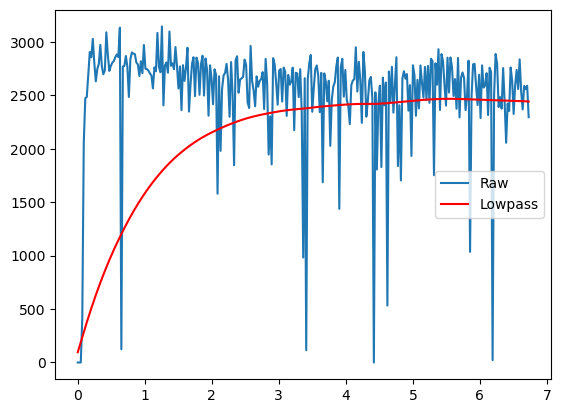

In [55]:
a_df_int = df9v70_2['acc_d'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v70_2['acc_d_filterd'] = data_lofilt

### デューティー比が80

In [57]:
fp = 5.8 # 通過域端周波数[Hz]：指定した周波数以下は減衰を受けない
fs = 5.9# 阻止域端周波数[Hz]：指定した周波数以上は減衰を受ける
gpass = 33 # 通過域端最大損失[dB]
gstop = 33.1 # 阻止域端最小損失[dB]
x = np.arange(0, 301) / samplerate

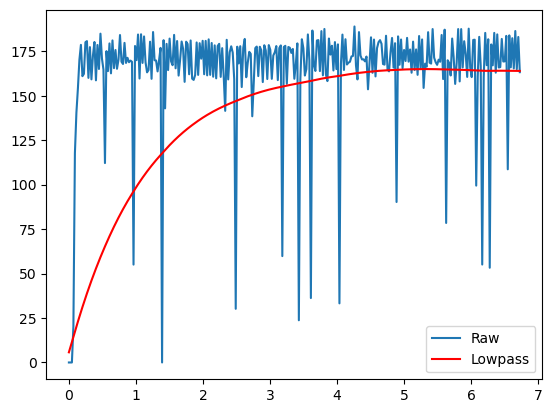

In [58]:
a_df_int = df9v80_2['dps_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v80_2['dps_a_filterd'] = data_lofilt

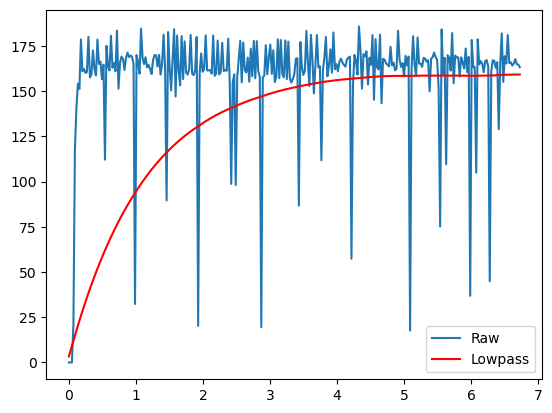

In [59]:
a_df_int = df9v80_2['dps_d'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v80_2['dps_d_filterd'] = data_lofilt

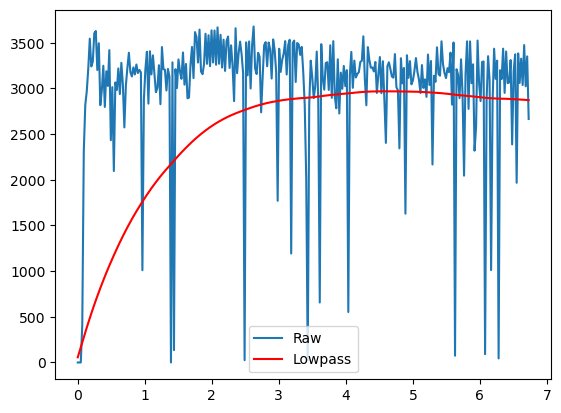

In [60]:
a_df_int = df9v80_2['acc_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v80_2['acc_a_filterd'] = data_lofilt

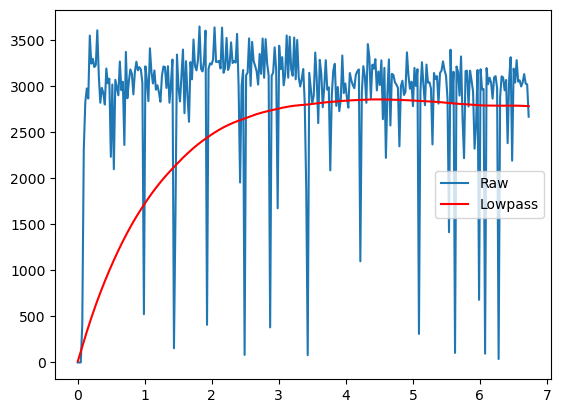

In [61]:
a_df_int = df9v80_2['acc_d'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v80_2['acc_d_filterd'] = data_lofilt

### デューティー比が90

In [63]:
fp = 5.8 # 通過域端周波数[Hz]：指定した周波数以下は減衰を受けない
fs = 5.9# 阻止域端周波数[Hz]：指定した周波数以上は減衰を受ける
gpass = 33 # 通過域端最大損失[dB]
gstop = 33.1 # 阻止域端最小損失[dB]
x = np.arange(0, 301) / samplerate

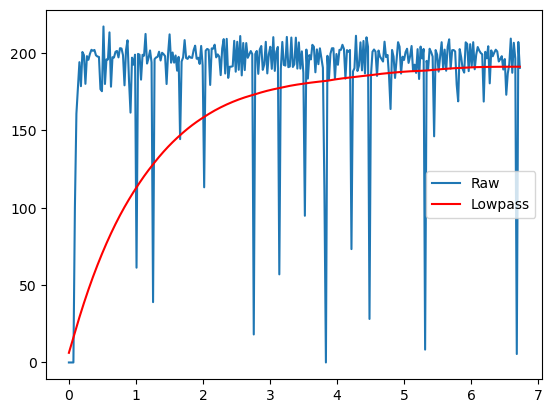

In [64]:
a_df_int = df9v90_2['dps_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v90_2['dps_a_filterd'] = data_lofilt

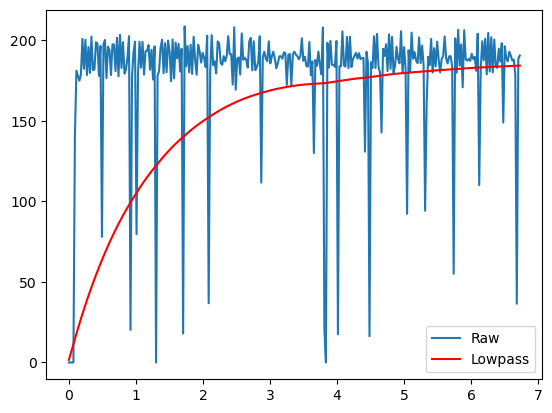

In [65]:
a_df_int = df9v90_2['dps_d'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v90_2['dps_d_filterd'] = data_lofilt

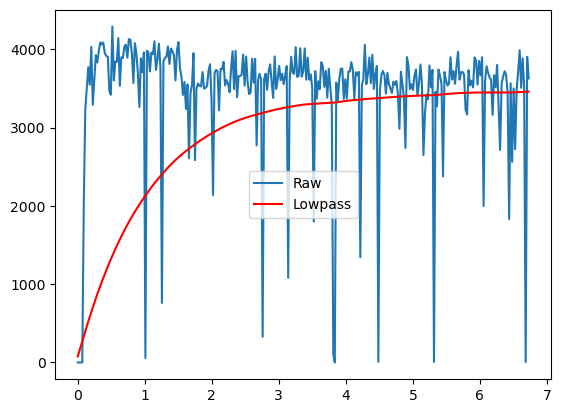

In [66]:
a_df_int = df9v90_2['acc_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v90_2['acc_a_filterd'] = data_lofilt

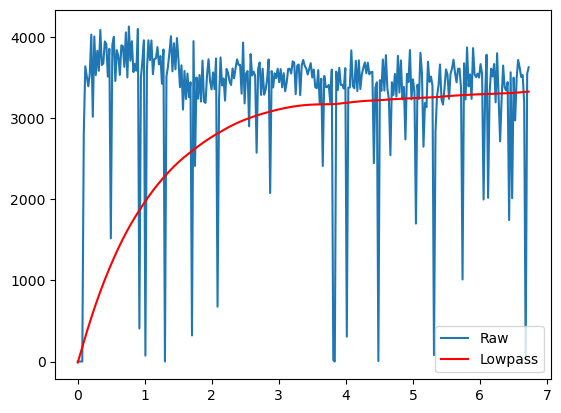

In [67]:
a_df_int = df9v90_2['acc_d'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v90_2['acc_d_filterd'] = data_lofilt

### デューティー比が100

In [69]:
fp = 5.8 # 通過域端周波数[Hz]：指定した周波数以下は減衰を受けない
fs = 5.9# 阻止域端周波数[Hz]：指定した周波数以上は減衰を受ける
gpass = 33 # 通過域端最大損失[dB]
gstop = 33.1 # 阻止域端最小損失[dB]
x = np.arange(0, 301) / samplerate

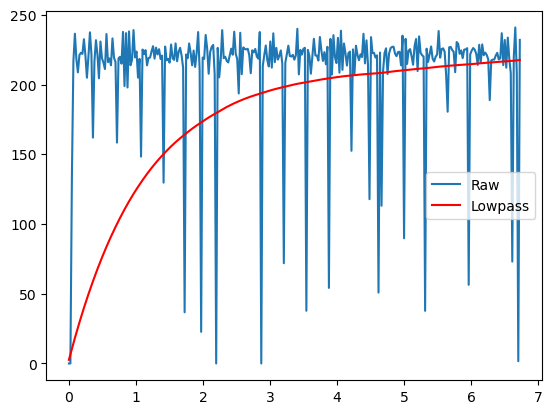

In [70]:
a_df_int = df9v100_2['dps_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v100_2['dps_a_filterd'] = data_lofilt

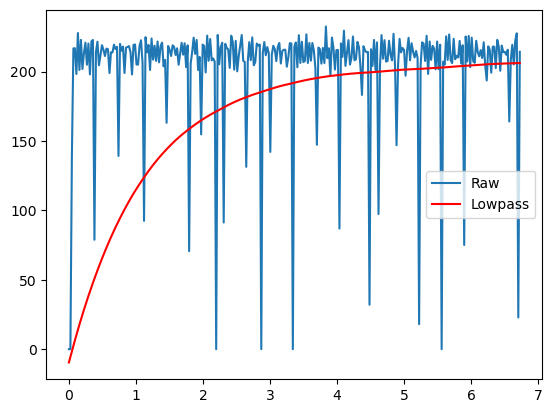

In [71]:
a_df_int = df9v100_2['dps_d'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v100_2['dps_d_filterd'] = data_lofilt

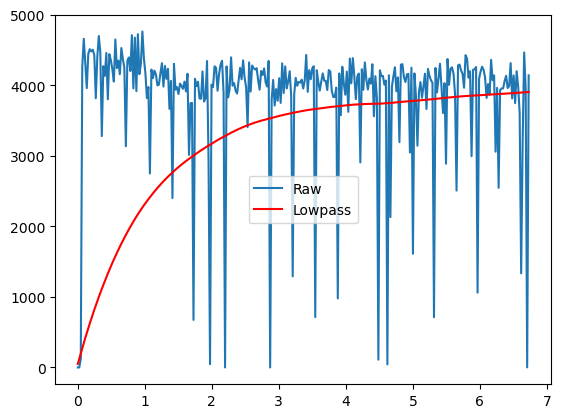

In [72]:
a_df_int = df9v100_2['acc_a'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v100_2['acc_a_filterd'] = data_lofilt

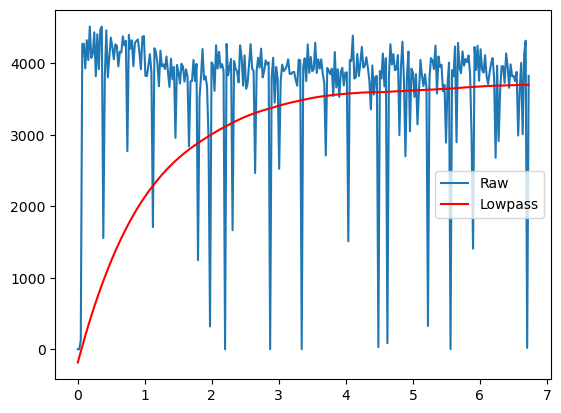

In [73]:
a_df_int = df9v100_2['acc_d'].values
data_lofilt = lowpass(a_df_int, samplerate, fp, fs, gpass, gstop)
plt.plot(x,a_df_int)
plt.plot(x ,data_lofilt,'r')
plt.legend(['Raw','Lowpass'])
df9v100_2['acc_d_filterd'] = data_lofilt

## 実験結果とシミュレーションの比較

### pwm_value = 10/0.9[v]

In [76]:
max_dps_a = df9v10_2['dps_a_filterd'].max()
th_a = max_dps_a * 0.632
tau_a = 0
max_dps_d = df9v10_2['dps_d_filterd'].max()
th_b = max_dps_d * 0.632
tau_b = 0
for index, row in df9v10_2.iterrows():
    if row['dps_a_filterd'] > th_a and tau_a == 0:
        tau_a = row['time']
    if row['dps_d_filterd'] > th_b and tau_b == 0:
        tau_b = row['time']
print(max_dps_a)
print(th_a)
print(tau_a)

13.20171367984116
8.343483045659612
4.875940084457397


<TransferFunction>: sys[0]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


      100
----------------
s^2 + 17 s + 100



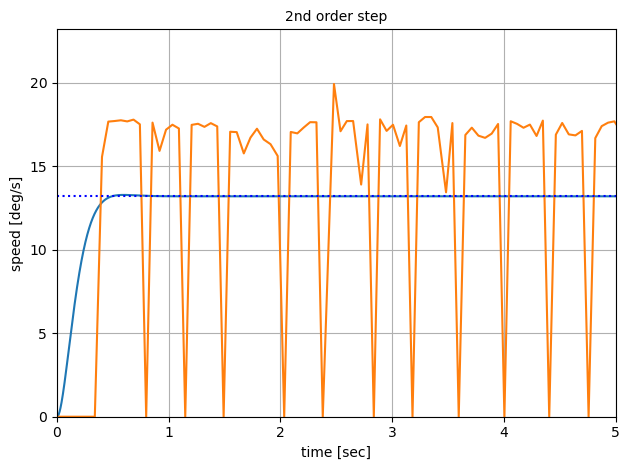

In [77]:
zeta = 0.85
omega_n = 10
z_c = max_dps_a
max_dps_a9v10 = max_dps_a
Kp = 1

x_max = 5
y_max = max_dps_a + 10
steps = 10000

# 伝達関数モデル作成
G2nd = tf_2nd_order(zeta, omega_n)

# 伝達関数モデル出力
print(G2nd)

# ステップ応答
t = np.linspace(0, x_max, steps)
(output, t) = matlab.step(G2nd, t)

#plot_line(output, t, z_c, x_max, y_max)
plot_line_over_experimental_data(output, t, z_c, x_max, y_max, df9v10_2['time'].values, df9v10_2['dps_a'].values)

### pwm_value = 20/1.8[v]

In [79]:
max_dps_a = df9v20_2['dps_a_filterd'].max()
th_a = max_dps_a * 0.632
tau_a = 0
max_dps_d = df9v20_2['dps_d_filterd'].max()
th_b = max_dps_d * 0.632
tau_b = 0
for index, row in df9v20_2.iterrows():
    if row['dps_a_filterd'] > th_a and tau_a == 0:
        tau_a = row['time']
    if row['dps_d_filterd'] > th_b and tau_b == 0:
        tau_b = row['time']
print(max_dps_a)
print(th_a)
print(tau_a)

27.689261727983325
17.499613412085463
6.405165910720825


<TransferFunction>: sys[2]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


      100
----------------
s^2 + 17 s + 100



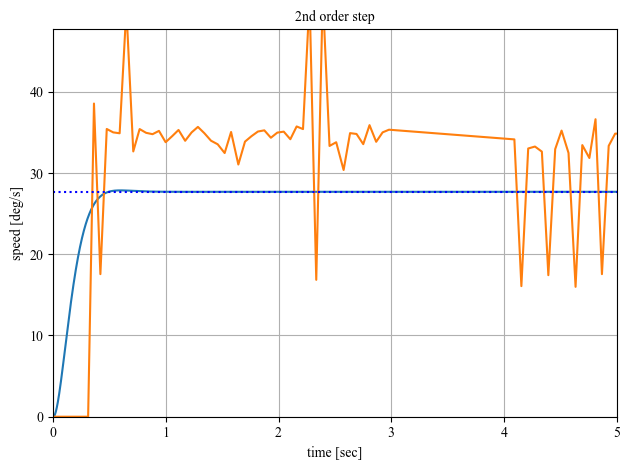

In [80]:
zeta = 0.85
omega_n = 10
z_c = max_dps_a
max_dps_a9v20 = max_dps_a
Kp = 1

x_max = 5
y_max = max_dps_a + 20
steps = 10000

# 伝達関数モデル作成
G2nd = tf_2nd_order(zeta, omega_n)

# 伝達関数モデル出力
print(G2nd)

# ステップ応答
t = np.linspace(0, x_max, steps)
(output, t) = matlab.step(G2nd, t)

#plot_line(output, t, z_c, x_max, y_max)
plot_line_over_experimental_data(output, t, z_c, x_max, y_max, df9v20_2['time'].values, df9v20_2['dps_a'].values)

In [81]:
(a_max, t_peak) = get_peak(z_c * output, t)
print(a_max - z_c)
print(t_peak)
(a_m, b_m) = calc_param_ab((a_max - z_c), t_peak, Kp, z_c)
print("a_m : " + str(a_m))
print("b_m : " + str(b_m))

0.17409880568567004
0.5965596559655966
omega_nc : 9.996882933339972
zeta_c : 0.8500000804901134
a_m : 16.994702595978435
b_m : 99.937668382904


### pwm_value = 30/2.7[v]

In [83]:
max_dps_a = df9v30_2['dps_a_filterd'].max()
th_a = max_dps_a * 0.632
tau_a = 0
max_dps_d = df9v30_2['dps_d_filterd'].max()
th_b = max_dps_d * 0.632
tau_b = 0
for index, row in df9v30_2.iterrows():
    if row['dps_a_filterd'] > th_a and tau_a == 0:
        tau_a = row['time']
    if row['dps_d_filterd'] > th_b and tau_b == 0:
        tau_b = row['time']
print(max_dps_a)
print(th_a)
print(tau_a)

55.49810568852509
35.07480279514785
3.515480995178222


<TransferFunction>: sys[4]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


      100
----------------
s^2 + 17 s + 100



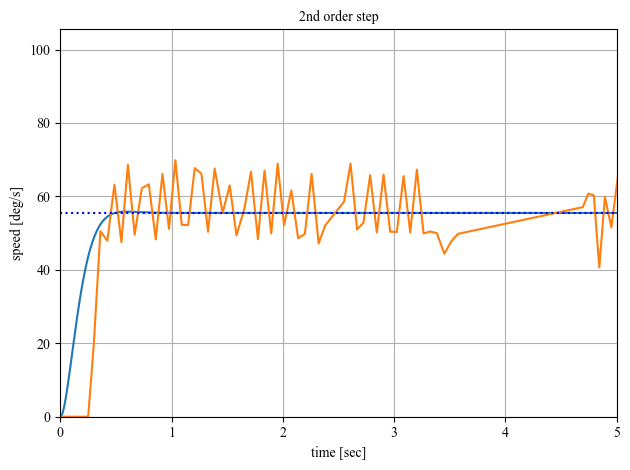

In [84]:
zeta = 0.85
omega_n = 10
z_c = max_dps_a
max_dps_a9v30 = max_dps_a
Kp = 1

x_max = 5
y_max = max_dps_a + 50
steps = 10000

# 伝達関数モデル作成
G2nd = tf_2nd_order(zeta, omega_n)

# 伝達関数モデル出力
print(G2nd)

# ステップ応答
t = np.linspace(0, x_max, steps)
(output, t) = matlab.step(G2nd, t)

plot_line_over_experimental_data(output, t, z_c, x_max, y_max, df9v30_2['time'].values, df9v30_2['dps_a'].values)

In [85]:
(a_max, t_peak) = get_peak(z_c * output, t)
print(a_max - z_c)
print(t_peak)
(a_m, b_m) = calc_param_ab((a_max - z_c), t_peak, Kp, z_c)
print("a_m : " + str(a_m))
print("b_m : " + str(b_m))

0.3489494957687711
0.5965596559655966
omega_nc : 9.996882933339972
zeta_c : 0.8500000804901134
a_m : 16.994702595978435
b_m : 99.937668382904


### pwm_value = 40/3.6[v]

In [87]:
max_dps_a = df9v40_2['dps_a_filterd'].max()
th_a = max_dps_a * 0.632
tau_a = 0
max_dps_d = df9v40_2['dps_d_filterd'].max()
th_b = max_dps_d * 0.632
tau_b = 0
for index, row in df9v40_2.iterrows():
    if row['dps_a_filterd'] > th_a and tau_a == 0:
        tau_a = row['time']
    if row['dps_d_filterd'] > th_b and tau_b == 0:
        tau_b = row['time']
print(max_dps_a)
print(th_a)
print(tau_a)

76.21181858050154
48.165869342876974
3.766829252243041


<TransferFunction>: sys[6]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


      100
----------------
s^2 + 17 s + 100



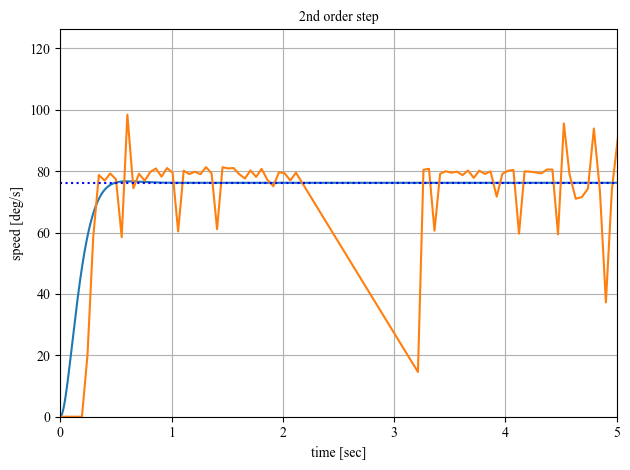

In [88]:
zeta = 0.85
omega_n = 10
z_c = max_dps_a
max_dps_a9v40 = max_dps_a
Kp = 1

x_max = 5
y_max = max_dps_a + 50
steps = 10000

# 伝達関数モデル作成
G2nd = tf_2nd_order(zeta, omega_n)

# 伝達関数モデル出力
print(G2nd)

# ステップ応答
t = np.linspace(0, x_max, steps)
(output, t) = matlab.step(G2nd, t)

plot_line_over_experimental_data(output, t, z_c, x_max, y_max, df9v40_2['time'].values, df9v40_2['dps_a'].values)

In [89]:
(a_max, t_peak) = get_peak(z_c * output, t)
print(a_max - z_c)
print(t_peak)
(a_m, b_m) = calc_param_ab((a_max - z_c), t_peak, Kp, z_c)
print("a_m : " + str(a_m))
print("b_m : " + str(b_m))

0.4791888900594614
0.5965596559655966
omega_nc : 9.996882933339974
zeta_c : 0.8500000804901134
a_m : 16.99470259597844
b_m : 99.93766838290404


### pwm_value = 50/4.5[v]

In [91]:
max_dps_a = df9v50_2['dps_a_filterd'].max()
th_a = max_dps_a * 0.632
tau_a = 0
max_dps_d = df9v50_2['dps_d_filterd'].max()
th_b = max_dps_d * 0.632
tau_b = 0
for index, row in df9v50_2.iterrows():
    if row['dps_a_filterd'] > th_a and tau_a == 0:
        tau_a = row['time']
    if row['dps_d_filterd'] > th_b and tau_b == 0:
        tau_b = row['time']
print(max_dps_a)
print(th_a)
print(tau_a)

100.2815394673799
63.377932943384096
2.4422764778137194


<TransferFunction>: sys[8]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


      100
----------------
s^2 + 17 s + 100



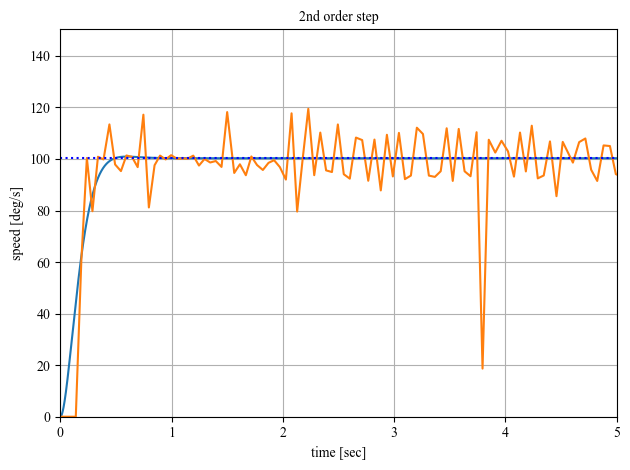

In [92]:
zeta = 0.85
omega_n = 10
z_c = max_dps_a
max_dps_a9v50 = max_dps_a
Kp = 1

x_max = 5
y_max = max_dps_a + 50
steps = 10000

# 伝達関数モデル作成
G2nd = tf_2nd_order(zeta, omega_n)

# 伝達関数モデル出力
print(G2nd)

# ステップ応答
t = np.linspace(0, x_max, steps)
(output, t) = matlab.step(G2nd, t)

plot_line_over_experimental_data(output, t, z_c, x_max, y_max, df9v50_2['time'].values, df9v50_2['dps_a'].values)

In [93]:
(a_max, t_peak) = get_peak(z_c * output, t)
print(a_max - z_c)
print(t_peak)
(a_m, b_m) = calc_param_ab((a_max - z_c), t_peak, Kp, z_c)
print("a_m : " + str(a_m))
print("b_m : " + str(b_m))

0.6305294964201664
0.5965596559655966
omega_nc : 9.996882933339949
zeta_c : 0.8500000804901128
a_m : 16.99470259597838
b_m : 99.93766838290354


### pwm_value = 60/5.4[v]

In [95]:
max_dps_a = df9v60_2['dps_a_filterd'].max()
th_a = max_dps_a * 0.632
tau_a = 0
max_dps_d = df9v60_2['dps_d_filterd'].max()
th_b = max_dps_d * 0.632
tau_b = 0
for index, row in df9v60_2.iterrows():
    if row['dps_a_filterd'] > th_a and tau_a == 0:
        tau_a = row['time']
    if row['dps_d_filterd'] > th_b and tau_b == 0:
        tau_b = row['time']
print(max_dps_a)
print(th_a)
print(tau_a)

122.84895204723153
77.64053769385033
3.2929928302764884


<TransferFunction>: sys[10]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


      100
----------------
s^2 + 17 s + 100



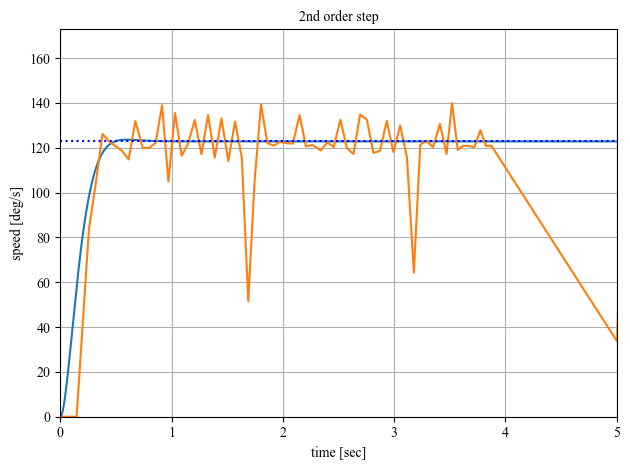

In [96]:
zeta = 0.85
omega_n = 10
z_c = max_dps_a
max_dps_a9v60 = max_dps_a
Kp = 1

x_max = 5
y_max = max_dps_a + 50
steps = 10000

# 伝達関数モデル作成
G2nd = tf_2nd_order(zeta, omega_n)

# 伝達関数モデル出力
print(G2nd)

# ステップ応答
t = np.linspace(0, x_max, steps)
(output, t) = matlab.step(G2nd, t)

plot_line_over_experimental_data(output, t, z_c, x_max, y_max, df9v60_2['time'].values, df9v60_2['dps_a'].values)

In [97]:
(a_max, t_peak) = get_peak(z_c * output, t)
print(a_max - z_c)
print(t_peak)
(a_m, b_m) = calc_param_ab((a_max - z_c), t_peak, Kp, z_c)
print("a_m : " + str(a_m))
print("b_m : " + str(b_m))

0.7724241997230479
0.5965596559655966
omega_nc : 9.996882933339949
zeta_c : 0.8500000804901126
a_m : 16.994702595978378
b_m : 99.93766838290354


### pwm_value = 70/6.3[v]

In [99]:
max_dps_a = df9v70_2['dps_a_filterd'].max()
th_a = max_dps_a * 0.632
tau_a = 0
max_dps_d = df9v70_2['dps_d_filterd'].max()
th_b = max_dps_d * 0.632
tau_b = 0
for index, row in df9v70_2.iterrows():
    if row['dps_a_filterd'] > th_a and tau_a == 0:
        tau_a = row['time']
    if row['dps_d_filterd'] > th_b and tau_b == 0:
        tau_b = row['time']
print(max_dps_a)
print(th_a)
print(tau_a)

135.97016405393794
85.93314368208878
3.3386683464050284


<TransferFunction>: sys[12]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


      100
----------------
s^2 + 17 s + 100



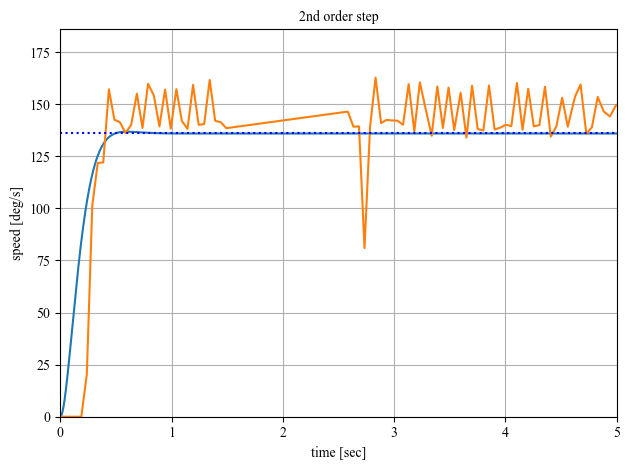

In [100]:
zeta = 0.85
omega_n = 10
z_c = max_dps_a
max_dps_a9v70 = max_dps_a
Kp = 1

x_max = 5
y_max = max_dps_a + 50
steps = 10000

# 伝達関数モデル作成
G2nd = tf_2nd_order(zeta, omega_n)

# 伝達関数モデル出力
print(G2nd)

# ステップ応答
t = np.linspace(0, x_max, steps)
(output, t) = matlab.step(G2nd, t)

plot_line_over_experimental_data(output, t, z_c, x_max, y_max, df9v70_2['time'].values, df9v70_2['dps_a'].values)

In [101]:
(a_max, t_peak) = get_peak(z_c * output, t)
print(a_max - z_c)
print(t_peak)
(a_m, b_m) = calc_param_ab((a_max - z_c), t_peak, Kp, z_c)
print("a_m : " + str(a_m))
print("b_m : " + str(b_m))

0.8549250392888439
0.5965596559655966
omega_nc : 9.996882933339972
zeta_c : 0.8500000804901134
a_m : 16.994702595978435
b_m : 99.937668382904


### pwm_value = 80/7.2[v]

In [103]:
max_dps_a = df9v80_2['dps_a_filterd'].max()
th_a = max_dps_a * 0.632
tau_a = 0
max_dps_d = df9v80_2['dps_d_filterd'].max()
th_b = max_dps_d * 0.632
tau_b = 0
for index, row in df9v80_2.iterrows():
    if row['dps_a_filterd'] > th_a and tau_a == 0:
        tau_a = row['time']
    if row['dps_d_filterd'] > th_b and tau_b == 0:
        tau_b = row['time']
print(max_dps_a)
print(th_a)
print(tau_a)

165.00105364532794
104.28066590384726
2.7106592655181876


<TransferFunction>: sys[14]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


      100
----------------
s^2 + 17 s + 100



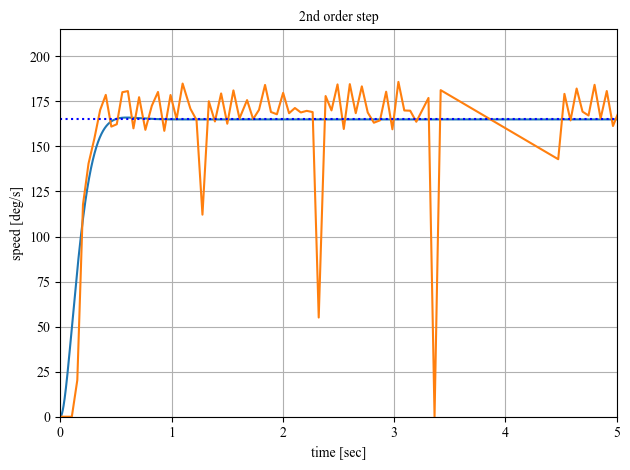

In [104]:
zeta = 0.85
omega_n = 10
z_c = max_dps_a
max_dps_a9v80 = max_dps_a
Kp = 1

x_max = 5
y_max = max_dps_a + 50
steps = 10000

# 伝達関数モデル作成
G2nd = tf_2nd_order(zeta, omega_n)

# 伝達関数モデル出力
print(G2nd)

# ステップ応答
t = np.linspace(0, x_max, steps)
(output, t) = matlab.step(G2nd, t)

plot_line_over_experimental_data(output, t, z_c, x_max, y_max, df9v80_2['time'].values, df9v80_2['dps_a'].values)

In [105]:
(a_max, t_peak) = get_peak(z_c * output, t)
print(a_max - z_c)
print(t_peak)
(a_m, b_m) = calc_param_ab((a_max - z_c), t_peak, Kp, z_c)
print("a_m : " + str(a_m))
print("b_m : " + str(b_m))

1.037459454814467
0.5965596559655966
omega_nc : 9.996882933339977
zeta_c : 0.8500000804901136
a_m : 16.994702595978445
b_m : 99.9376683829041


### pwm_value = 90/8.1[v]

In [107]:
max_dps_a = df9v90_2['dps_a_filterd'].max()
th_a = max_dps_a * 0.632
tau_a = 0
max_dps_d = df9v90_2['dps_d_filterd'].max()
th_b = max_dps_d * 0.632
tau_b = 0
for index, row in df9v90_2.iterrows():
    if row['dps_a_filterd'] > th_a and tau_a == 0:
        tau_a = row['time']
    if row['dps_d_filterd'] > th_b and tau_b == 0:
        tau_b = row['time']
print(max_dps_a)
print(th_a)
print(tau_a)

191.2349117763821
120.86046424267349
3.77795648574829


<TransferFunction>: sys[16]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


      100
----------------
s^2 + 17 s + 100



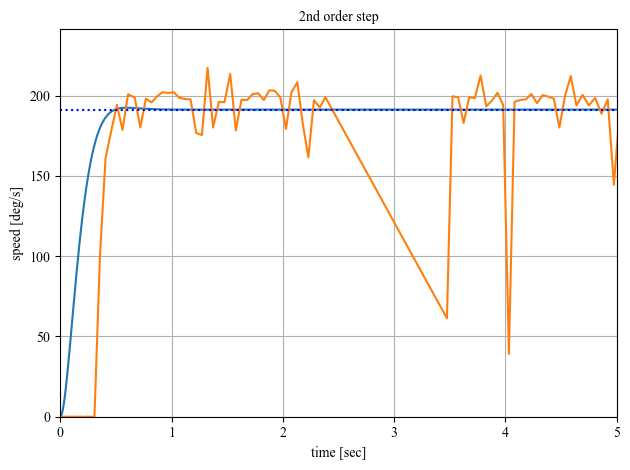

In [108]:
zeta = 0.85
omega_n = 10
z_c = max_dps_a
max_dps_a9v90 = max_dps_a
Kp = 1

x_max = 5
y_max = max_dps_a + 50
steps = 10000

# 伝達関数モデル作成
G2nd = tf_2nd_order(zeta, omega_n)

# 伝達関数モデル出力
print(G2nd)

# ステップ応答
t = np.linspace(0, x_max, steps)
(output, t) = matlab.step(G2nd, t)

plot_line_over_experimental_data(output, t, z_c, x_max, y_max, df9v90_2['time'].values, df9v90_2['dps_a'].values)

In [109]:
(a_max, t_peak) = get_peak(z_c * output, t)
print(a_max - z_c)
print(t_peak)
(a_m, b_m) = calc_param_ab((a_max - z_c), t_peak, Kp, z_c)
print("a_m : " + str(a_m))
print("b_m : " + str(b_m))

1.2024072751649157
0.5965596559655966
omega_nc : 9.996882933339972
zeta_c : 0.8500000804901134
a_m : 16.994702595978435
b_m : 99.937668382904


### pwm_value = 100/5.0[v]

In [111]:
max_dps_a = df9v100_2['dps_a_filterd'].max()
th_a = max_dps_a * 0.632
tau_a = 0
max_dps_d = df9v100_2['dps_d_filterd'].max()
th_b = max_dps_d * 0.632
tau_b = 0
for index, row in df9v100_2.iterrows():
    if row['dps_a_filterd'] > th_a and tau_a == 0:
        tau_a = row['time']
    if row['dps_d_filterd'] > th_b and tau_b == 0:
        tau_b = row['time']
print(max_dps_a)
print(th_a)
print(tau_a)

217.62497005090412
137.5389810721714
3.7863667011260986


<TransferFunction>: sys[18]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


      100
----------------
s^2 + 17 s + 100



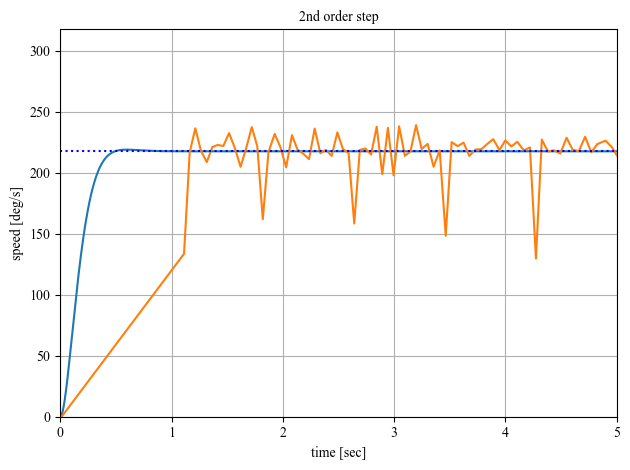

In [112]:
zeta = 0.85
omega_n = 10
z_c = max_dps_a
max_dps_a9v100 = max_dps_a
Kp = 1

x_max = 5
y_max = max_dps_a + 100
steps = 10000
9
# 伝達関数モデル作成
G2nd = tf_2nd_order(zeta, omega_n)

# 伝達関数モデル出力
print(G2nd)

# ステップ応答
t = np.linspace(0, x_max, steps)
(output, t) = matlab.step(G2nd, t)

plot_line_over_experimental_data(output, t, z_c, x_max, y_max, df9v100_2['time'].values, df9v100_2['dps_a'].values)

In [113]:
(a_max, t_peak) = get_peak(z_c * output, t)
print(a_max - z_c)
print(t_peak)
(a_m, b_m) = calc_param_ab((a_max - z_c), t_peak, Kp, z_c)
print("a_m : " + str(a_m))
print("b_m : " + str(b_m))

1.3683372184297582
0.5965596559655966
omega_nc : 9.996882933339966
zeta_c : 0.8500000804901132
a_m : 16.99470259597842
b_m : 99.9376683829039


## デューティー比と角速度の関係(5V)

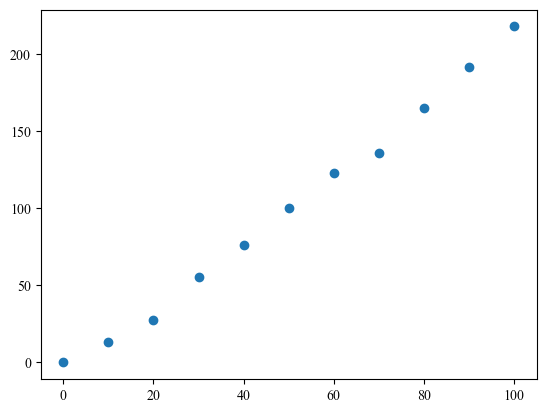

In [115]:
data = [
    [0, 0]
    ,[10, max_dps_a9v10]
    ,[20, max_dps_a9v20]
    ,[30, max_dps_a9v30]
    ,[40, max_dps_a9v40]
    ,[50, max_dps_a9v50]
    ,[60, max_dps_a9v60]
    ,[70, max_dps_a9v70]
    ,[80, max_dps_a9v80]
    ,[90, max_dps_a9v90]
    ,[100, max_dps_a9v100]
]

df_dps = pd.DataFrame(data=data, columns=['duty-cycle', 'dps'])
x = df_dps[['duty-cycle']]
y = df_dps[['dps']]

plt.plot(x, y, 'o')
plt.show()

In [116]:
model_lr = LinearRegression()
model_lr.fit(x, y)

LinearRegression()

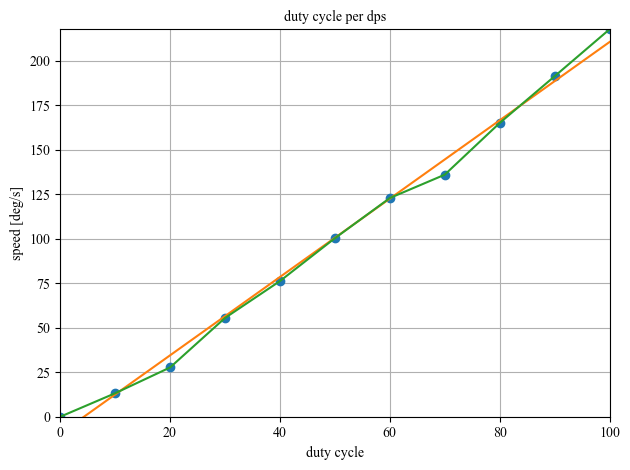

In [117]:
x_max=df_dps['duty-cycle'].max()
y_max=df_dps['dps'].max()

plt.plot(x, y, 'o')
plt.plot(x, model_lr.predict(x), linestyle="solid")
# 出力パラメータ
plt.plot(df_dps['duty-cycle'], df_dps['dps'])
plt.rcParams['font.family'] = 'Times New Roman' # 全体のフォント
plt.title('duty cycle per dps', fontsize=10)        # グラフタイトル
plt.xlabel('duty cycle', fontsize=10)           # x軸ラベル
plt.ylabel('speed [deg/s]', fontsize=10)               # y軸ラベル
plt.xlim([0, x_max])                              # x軸範囲
plt.ylim([0, y_max])                              # y軸範囲
plt.tick_params(labelsize = 10)                 # 軸ラベルの目盛りサイズ
plt.tight_layout()                              # ラベルがきれいに収まるよう表示
plt.grid()                                      # グリッド表示
plt.show()

In [118]:
print('モデル関数の回帰変数 w1: %.3f' %model_lr.coef_)
print('モデル関数の切片 w2: %.3f' %model_lr.intercept_)
print('y= %.3fx + %.3f' % (model_lr.coef_ , model_lr.intercept_))
print('決定係数 ： ', model_lr.score(x, y))

モデル関数の回帰変数 w1: 2.200
モデル関数の切片 w2: -9.484
y= 2.200x + -9.484
決定係数 ：  0.9948270799898393


C:\Users\sheep\AppData\Local\Temp\ipykernel_10468\3150842204.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('モデル関数の回帰変数 w1: %.3f' %model_lr.coef_)
C:\Users\sheep\AppData\Local\Temp\ipykernel_10468\3150842204.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('モデル関数の切片 w2: %.3f' %model_lr.intercept_)
C:\Users\sheep\AppData\Local\Temp\ipykernel_10468\3150842204.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('y= %.3fx + %.3f' % (model_lr.c

## デューティー比と角加速度の関係(5V)

In [120]:
max_acc_a9v10 = df9v10_2['acc_a_filterd'].max()
max_acc_d9v10 = df9v10_2['acc_d_filterd'].max()
max_acc_a9v20 = df9v20_2['acc_a_filterd'].max()
max_acc_d9v20 = df9v20_2['acc_d_filterd'].max()
max_acc_a9v30 = df9v30_2['acc_a_filterd'].max()
max_acc_d9v30 = df9v30_2['acc_d_filterd'].max()
max_acc_a9v40 = df9v40_2['acc_a_filterd'].max()
max_acc_d9v40 = df9v40_2['acc_d_filterd'].max()
max_acc_a9v50 = df9v50_2['acc_a_filterd'].max()
max_acc_d9v50 = df9v50_2['acc_d_filterd'].max()
max_acc_a9v60 = df9v60_2['acc_a_filterd'].max()
max_acc_d9v60 = df9v60_2['acc_d_filterd'].max()
max_acc_a9v70 = df9v70_2['acc_a_filterd'].max()
max_acc_d9v70 = df9v70_2['acc_d_filterd'].max()
max_acc_a9v80 = df9v80_2['acc_a_filterd'].max()
max_acc_d9v80 = df9v80_2['acc_d_filterd'].max()
max_acc_a9v90 = df9v90_2['acc_a_filterd'].max()
max_acc_d9v90 = df9v90_2['acc_d_filterd'].max()
max_acc_a9v100 = df9v100_2['acc_a_filterd'].max()
max_acc_d9v100 = df9v100_2['acc_d_filterd'].max()

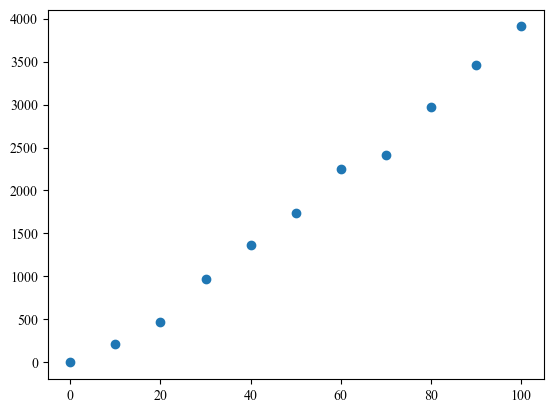

In [121]:
data = [
    [0, 0]
    ,[10, max_acc_a9v10]
    ,[20, max_acc_a9v20]
    ,[30, max_acc_a9v30]
    ,[40, max_acc_a9v40]
    ,[50, max_acc_a9v50]
    ,[60, max_acc_a9v60]
    ,[70, max_acc_a9v70]
    ,[80, max_acc_a9v80]
    ,[90, max_acc_a9v90]
    ,[100, max_acc_a9v100]
]

df_acc = pd.DataFrame(data=data, columns=['duty-cycle', 'acc'])
x = df_acc[['duty-cycle']]
y = df_acc[['acc']]

plt.plot(x, y, 'o')
plt.show()

In [122]:
model_lr = LinearRegression()
model_lr.fit(x, y)

LinearRegression()

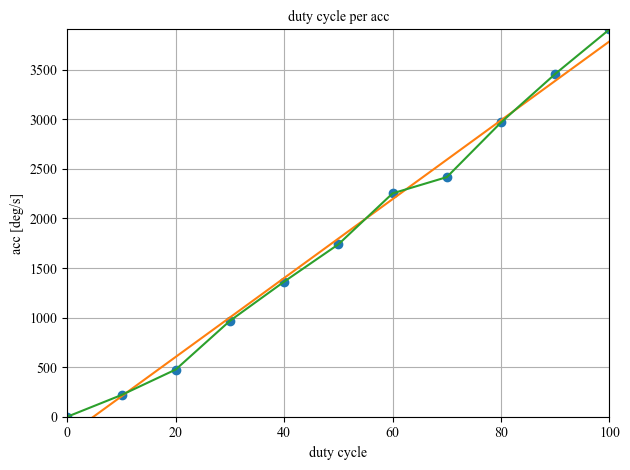

In [123]:
x_max=df_acc['duty-cycle'].max()
y_max=df_acc['acc'].max()

plt.plot(x, y, 'o')
plt.plot(x, model_lr.predict(x), linestyle="solid")
# 出力パラメータ
plt.plot(df_acc['duty-cycle'], df_acc['acc'])
plt.rcParams['font.family'] = 'Times New Roman' # 全体のフォント
plt.title('duty cycle per acc', fontsize=10)        # グラフタイトル
plt.xlabel('duty cycle', fontsize=10)           # x軸ラベル
plt.ylabel('acc [deg/s]', fontsize=10)               # y軸ラベル
plt.xlim([0, x_max])                              # x軸範囲
plt.ylim([0, y_max])                              # y軸範囲
plt.tick_params(labelsize = 10)                 # 軸ラベルの目盛りサイズ
plt.tight_layout()                              # ラベルがきれいに収まるよう表示
plt.grid()                                      # グリッド表示
plt.show()

In [124]:
print('モデル関数の回帰変数 w1: %.3f' %model_lr.coef_)
print('モデル関数の切片 w2: %.3f' %model_lr.intercept_)
print('y= %.3fx + %.3f' % (model_lr.coef_ , model_lr.intercept_))
print('決定係数 ： ', model_lr.score(x, y))

モデル関数の回帰変数 w1: 39.784
モデル関数の切片 w2: -192.066
y= 39.784x + -192.066
決定係数 ：  0.9935190816342226


C:\Users\sheep\AppData\Local\Temp\ipykernel_10468\3150842204.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('モデル関数の回帰変数 w1: %.3f' %model_lr.coef_)
C:\Users\sheep\AppData\Local\Temp\ipykernel_10468\3150842204.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('モデル関数の切片 w2: %.3f' %model_lr.intercept_)
C:\Users\sheep\AppData\Local\Temp\ipykernel_10468\3150842204.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('y= %.3fx + %.3f' % (model_lr.c

## モータ位置決め制御

## Export Data

In [127]:
t_delta = datetime.timedelta(hours=9)
JST = datetime.timezone(t_delta, 'JST')
now = datetime.datetime.now(JST)
d = now.strftime('%Y-%m-%d_%H:%M:%S')
print(d)

2024-07-12_22:41:55


In [128]:
#df2.to_csv('/home/uecadmin/researchScript/output_mufuka_test_pwm-0.2_002_' + file_index + '_' + str(d) + '.tsv', sep='\t', index=False)